In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
try:
    import seaborn as sns
except ModuleNotFoundError:
    print("""
You'll neeed to
    conda install seaborn
if you want to uncomment the lines like
    sns.set_palette(sns.color_palette("coolwarm",4))
to change the color palette of your plots.
""")


You'll neeed to
    conda install seaborn
if you want to uncomment the lines like
    sns.set_palette(sns.color_palette("coolwarm",4))
to change the color palette of your plots.



# Transient diffusion, PDEs, with method of lines

The example in the PDEs notebook covered in class was solving the concentration profile of component that diffuses into a 1D rod, with an impermeable barrier at the end.
It was done using finite difference method in both $x$ (distance along rod) and $t$ (time).
We observed the solution was numerically unstable - changing the diffusivity a little bit, or the number of slices of $x$, made the results go crazy.

The notes  said "Note that we cannot use the method of lines as we did before because we have the derivative-based boundary condition at one of the boundaries."
But this is not true! We're now going to solve it again using method of lines.
We just have to be a little bit clever with the ODE for the line at $x=L$.

We want to solve for the concentration profile of component that diffuses into a 1D rod, with an impermeable barrier at the end. The PDE governing this situation is:

$$\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}$$

In this example we have $C_0(x) = 0$ at $t=0$ as an initial condition, with boundary conditions $C(0,t)=0.1$ and $\frac{\partial C}{\partial x}(L,t)=0$.


We approximate the distance derivative as
$$\frac{\partial^2 C}{\partial  x^2} \bigg| _{i,t} \approx \frac{C_{i+1,t} - 2 C_{i,t} + C_{i-1,t}}{h^2} $$
but we will solve the time derivative using `solve_ivp`.

We define $\alpha = \frac{D}{h^2}$, and from these approximations and the PDE, we get the differential equations in time, for each location in the rod:

$$\frac{\partial C_i}{\partial t} = \alpha \left( C_{i+1,t} -  2  C_{i,t}  +  C_{i-1,t} \right) $$


For the start of the rod (first boundary condition) we have fixed concentration.

$$\frac{\partial C_0}{\partial t} = 0 $$

For the end of the rod (other boundary condition) we have no flux and hence no concentrtation gradient.
If $\frac{\partial C}{\partial x}\big|_N = 0$ then  $C_{N-1} = C_{N+1}$ 

Notice that in this notation $N$ is the last point and here $N+1$ is an imaginary point off the end of the rod.
We can use this equality to replace $C_{N+1}$ with $C_{N-1}$ and derive the ODE:
$$\frac{\partial C_N}{\partial t} = \alpha \left( 2 C_{N-1,t} -  2  C_{N,t} \right) $$.

**Warning!** beware that with a numpy array called `C` with $N$ elements the last point is in fact  `C[N-1]`. Maybe safer to refer to it as `C[-1]`, which will also let you change $N$ easily)

We know $C_{i,j=0}$ from the initial conditions.

so we simply need to solve the IVP to evaluate $C_{i,j}$.




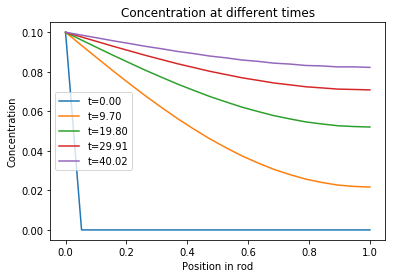

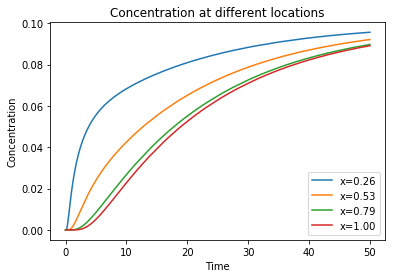

In [3]:
N = 20  # number of points to discretize
L = 1.0 # length of the rod
X = np.linspace(0, L, N) # position along the rod
h = L / (N - 1)          # discretization spacing

C0t = 0.1  # concentration at x = 0
D = 0.020  # Diffusivity

tfinal = 50.0  # final time

## NOW WRITE CODE TO TRY TO MAKE PLOTS LIKE THESE
## DON'T WORRY ABOUT GETTING EXACTLY THE SAME 
## TIMES ON THE FIRST PLOT OR X VALUES ON THE SECOND

###  Comparing the two ODE functions
I wrote two alternative `method_of_lines` functions, one using a for loop and one using `np.diff`.
First we should check the two methods of lines functions give the same results:

In [ ]:
C = sol.y[:,-1]
t = sol.t[-1]
method_of_lines(t,C) == method_of_lines2(t,C)

Then we could see which is faster

In [5]:
%%timeit
method_of_lines(t,C)

19.8 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
%%timeit
method_of_lines2(t,C)

11.6 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


If you find one easier to understand, and thus easier to debug, and your overall project is not annoyingly slow, then use the easier one. 
But let's see how different the speeds are if we were to have much more than 20 slices.
Let's try 1000:

1000

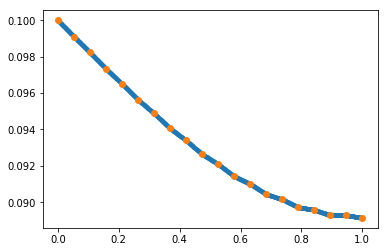

In [7]:
# Make fake_C with 1000 points by interpolating the real C with 20 points
fake_X = np.linspace(0,L,1000)
fake_C = np.interp(fake_X, X, C)
plt.plot(fake_X, fake_C, '.')
plt.plot(X, C,'o')
len(fake_C)

In [8]:
%%timeit
method_of_lines(t,fake_C)

843 µs ± 92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit
method_of_lines2(t,fake_C)

17.3 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


So it's now about 50 times faster. 
That could be a huge savings if you're doing a brute-force sensitivity analysis or Monte Carlo sampling or something and need to run it a lot of times.

But if we're just solving the PDEs once...

In [10]:
%%timeit
sol=solve_ivp(method_of_lines, (0,tfinal), fake_C)
sol.nfev

3.28 s ± 423 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
sol=solve_ivp(method_of_lines2, (0,tfinal), fake_C)
sol.nfev

158 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


...then the faster method is only going to save about 3 seconds of your day.